In [2]:
#第一课 BSM 公式即通过蒙特卡洛方式模拟估计欧式看涨期权价值。


import numpy as np

import matplotlib.pyplot as plt

S0 = 100. #当前股票价格
K = 105. #行权价
T = 1.0 #一年时间
r = 0.05 #固定无风险短期一年利率
sigma = 0.2 #固定波动率 20%

I = 100000  #为随机路径个数

z = np.random.standard_normal(I)   #每天有10000个变化数值

#根据BSM(1973)公式，简单计算T时间之后的股票价格ST，有I个价格
ST = S0 * np.exp((r - 0.5 * sigma * sigma) * T + sigma * np.sqrt(T) * z)
#计算到期期权的所有内在价值
hT = np.maximum(ST-K, 0)
#欧式期权的蒙特卡洛估算函数，求得期权当前的价值
C0 = np.exp(-r * T) * np.sum(hT) / I

print("value of european call option %5.3f" %(C0))




value of european call option 7.995


C:\Users\a\AppData\Local\conda\conda\envs\test_py3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


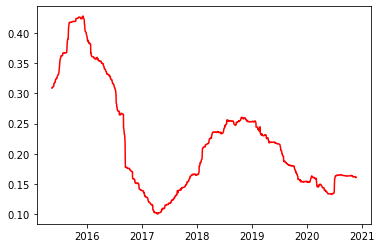

In [7]:
#第二课 一个简单的例子
#计算某个标的证券的波动率
import numpy as np
import pandas as pd
from datetime import datetime
#step1 ： 加载数据
df =pd.read_csv("./分析股票行情/601398_1d.csv")
df['date']= df['date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
#step2:  计算标的波动率，所谓波动率实际上是收益的标准差
df['Log_Ret']=np.log(df['close'] / df['close'].shift(1))
df['Volatility'] = df['Log_Ret'].rolling(252).std() * np.sqrt(252)

#step3:  绘制数据
%matplotlib inline
#df[['close','Volatility']].plot()

#plt.plot(df['date'],df['close'],'blue')
plt.plot(df['date'],df['Volatility'],'r')



In [52]:
# 第三课
#尽量使用库，性能高很多
from math import *
loops = 100000
a = range(1, loops)
def f(x):
    return 3*log(x) + cos(x)**2
%timeit r = [f(x) for x in a]


import numpy as np
a = np.arange(1, loops)
%timeit r = 3 *np.log(a) + np.cos(a)**2





58.2 ms ± 935 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.96 ms ± 9.63 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [126]:
#第四课
#隐含波动率
#根据BSM(1973)定价公式
#这个只是用于学习的，和我们实际用到的不大一样的。
from math import log, sqrt, exp
from scipy import stats

def bsm_call_value(S0, K, T, r, sigma):
    '''valuation of European call option in BSM model.
    Parameters
    =========
    S0 : float
        underlying instrument price 
    K: float
        strike price
    T: float
        from now to maturity date ( in year fractions)
    r: float
        constant risk-free short rate
    sigma: float
        volatility factor in diffusion term
    
    Returns
    =========
    value: float
        present value of the European call option
    '''
    S0 = float(S0)
    d1 = (log(S0/K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = (log(S0/K) + (r - 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    value = (S0 * stats.norm.cdf(d1, 0.0, 1.0) \
            - K * exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0))
    #cdf : 相当于已知正态分布函数曲线和x值，求函数x点左侧积分
    return value


def bsm_vega(S0, K, T, r, sigma):
    ''' vega of european option in BSM model
    Parameters
    =========
    S0 : float
            underlying instrument price
    K: float
            strike price
    T: float
            from now to maturity date ( in year fractions)
    r: float
            constant risk-free short rate
    sigma: float
            volatility factor in diffusion term
        
    Returns
    =========
    vega: float
        partial derivative of BSM formula with respect to sigma 
    '''

    S0 = float(S0)
    d1 = (log(S0/K) + (r + 0.5 * sigma ** 2) * T / (sigma * sqrt(T)))
    vega = S0 * stats.norm.cdf(d1, 0.0, 1.0) * sqrt(T)
    return vega

def bsm_call_imp_vol(S0, K, T, r, C0, sigma_est, it=100):
    '''
    Parameters
    ==========
    S0 : float
            underlying instrument price
    K: float
            strike price
    T: float
            from now to maturity date ( in year fractions)
    r: float
            constant risk-free short rate
    sigma_est: float
           estimate of impl. volatility
    it: integer
            number of iterations

    Returns
    ==========
    sigma_est : float
    '''
    for i in range(it):
        sigma_est -= ((bsm_call_value(S0, K, T, r, sigma_est) - C0) / bsm_vega(S0, K,T,r,sigma_est))
    return sigma_est


S0=100
K=105
T=1
r=0.05
underlying_v=0.2
C0=5


v1=bsm_call_value(S0,K,T,r,underlying_v)
v2=bsm_vega(S0,K,T,r,underlying_v)   #这个值和我们当前工作计算中的值不一样。
v3=bsm_call_imp_vol(S0,K,T,r,C0,0.1,100)
print("theoPrice=%f %f %f"%(v1,v2,v3))






    


theoPrice=8.021352 61.837275 0.123964


In [74]:
#第五课
# 纯python 进行欧式看涨期权的蒙特卡洛估值
# 在第一节课中也有，
#    只是第一节课中时间只有一步，而这里时间细分成了M步，可以理解为每步价格都会计算，比如日天数。
#    如下此时，M取1就接近第一课中的值，M取值越大，约消耗计算，这是个衡量。

from time import time
from math import exp, sqrt, log
from random import gauss, seed

seed(2000)
t0 = time()

S0 = 100.0
K = 105.0
T = 1.0
r = 0.05
sigma = 0.2
M = 50 # number of time steps
dt = T / M  # length of time interval
I = 25*10000

# Simulating I paths with M time steps
S = []
for i in range(I):
    path = []
    for t in range(M+1):
        if t == 0:
            path.append(S0)
        else:
            z = gauss(0.0, 1.0)
            St = path[t - 1] * exp((r - 0.5 * sigma ** 2) * dt + sigma * sqrt(dt) *z)
            path.append(St)
    S.append(path)

# Calculating the monte carlo estimator
C0 = exp(-r * T) * sum([max(path[-1] -K,0) for path in S]) / I

#Results output
tpy = time() - t0
print("European Option Value %7.3f" % C0)
print("Duration in Seconds %7.3f" % tpy)












European Option Value   8.011
Duration in Seconds  20.853


In [99]:
#第六节课 
# Numpy方式python 进行欧式看涨期权的蒙特卡洛估值
# 时间上，比第六课纯Python相比，时间为0.657，而纯python为20.853秒。

import numpy as np
import math
from time import time

np.random.seed(2000)
t0 = time()

S0 = 100.0
K = 105.0
T = 1.0
r = 0.05
sigma = 0.2
M = 50 # number of time steps
dt = T / M  # length of time interval
I = 25*10000

# Simulating I paths with M time steps
S = np.zeros((M+1,I))
S[0]=S0

for t in range(1,M+1):
    z = np.random.standard_normal(I)   # 一次性生成I个数据
    S[t] = S[t-1]* np.exp((r - 0.5*sigma **2)*dt + sigma * math.sqrt(dt) * z)  #一步生成I条路径的第t天数据
print(z.shape) # I 个
C0 = math.exp(-r * T) * np.sum(np.maximum(S[-1]-K,0)) / I

# Results output
tnp1 = time() - t0
print("European Option Value %7.3f" % C0)
print("Duration in Seconds   %7.3f" % tnp1)




(250000,)
European Option Value   8.018
Duration in Seconds     0.657


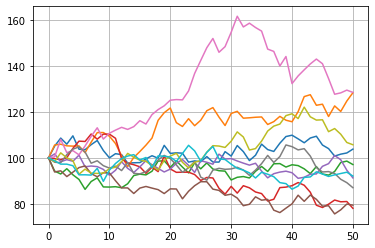

In [102]:
#第七课 1 
#画图，输出前10条路径所有时间step的数据
import matplotlib.pyplot as plt
plt.plot(S[:,:10])
plt.grid(True)
plt.xlabel('time step')
plt.ylabel('index level')


Text(0, 0.5, 'frequency')

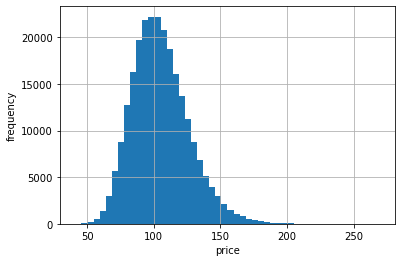

In [105]:
#第七课 2
#输出最后一天的所有路径的价格分布图
plt.hist(S[-1], bins=50)
plt.grid(True)
plt.xlabel('price')
plt.ylabel('frequency')


(0.0, 50000.0)

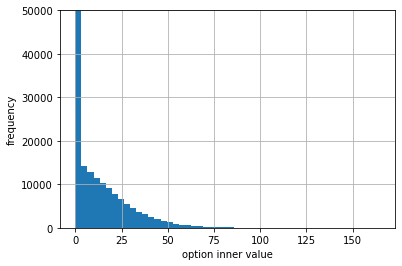

In [106]:
#第七课 3
#期权期末内在价值的图

plt.hist(np.maximum(S[-1] - K, 0), bins=50)
plt.grid(True)
plt.xlabel('option inner value')
plt.ylabel('frequency')
plt.ylim(0, 50000)




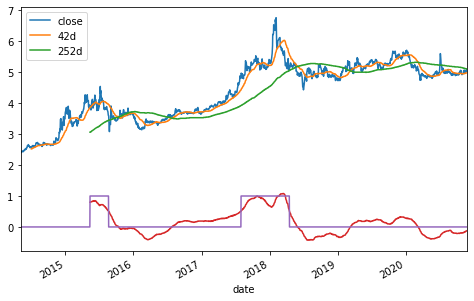

In [146]:
#第八课 
#接下来开始 技术分析,一个简单的例子，结果不重要，只是一个初步了解
import numpy as np
import pandas as pd
from datetime import datetime
#step1 ： 加载数据
df =pd.read_csv("./分析股票行情/601398_1d.csv")
df['date']= df['date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
#将时间列作为index
df.index = df['date']


#移动42天平均数，精确到小数点2位
df['42d'] = np.round(df['close'].rolling(42).mean(), 2)

df['252d'] = np.round(df['close'].rolling(252).mean(), 2)

df[['close','42d','252d']].plot(grid=True, figsize=(8, 5))

#计算42天和252天的移动平均数差值
df['42-252'] = df['42d'] - df['252d']
df['42-252'].plot()

#设定阈值SD
#假设0.5
SD1= 0.5
SD2= -0.5

#将大于SD的值，标志为1，小于标志为-1，等于标志为0，这样可以方便指导比率
df['regime'] = np.where(df['42-252']>SD1,1,0)
df['regime'] = np.where(df['42-252']<SD2,-1,df['regime'])
df['regime'].value_counts()
df[df['regime']==0].tail()
#假设短期趋势交叉长期趋势，则一段时间内，都会保持这个趋势，这就是投资体制(regime)
#通过图像可以看到，将原先波浪图变成了类似直方图，这个有点类似与滤波的感觉，也类似于电子电路专业中的模数转换。
df['regime'].plot()
#

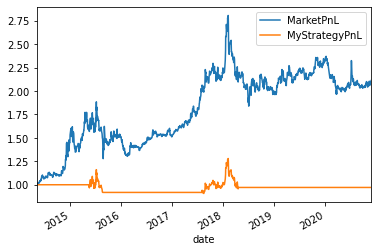

In [147]:
#计算每天的对数收益率
df['MarketPnL']=np.log(df['close'] / df['close'].shift(1))
#如果昨天的regime是做多，则收益是今天的market收益
df['MyStrategyPnL'] = df['regime'].shift(1) * df['MarketPnL']
#观察图，可以看到根据这个策略，交易机会不多
df[['MarketPnL','MyStrategyPnL']].cumsum().apply(np.exp).plot()

Text(0.5, 1.0, 'plot sample')

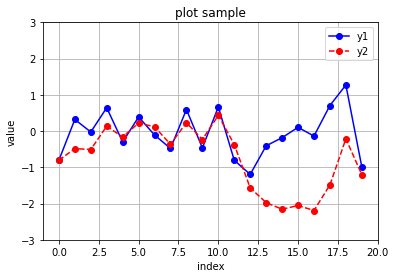

In [178]:
#第九课 
# 简单画图，跟之前用到的库相同，但是用法不一样
np.random.seed(1000)
y = np.random.standard_normal(20)
x = range(len(y))
y3 = y*100
plt.plot(x,y,'bo-',label='y1')
plt.plot(y.cumsum(),color='red',marker='o',linestyle='--',label='y2')
plt.legend(loc=0)
plt.grid(True)
plt.axis('tight')  #tight 使得所有数据可先   ,off关闭坐标轴和网格
plt.xlim(-1,20)  #横坐标范围
plt.ylim(-3,3)   #纵坐标范围
plt.xlabel('index')
plt.ylabel('value')
plt.title('plot sample')


Text(0, 0.5, 'value y2')

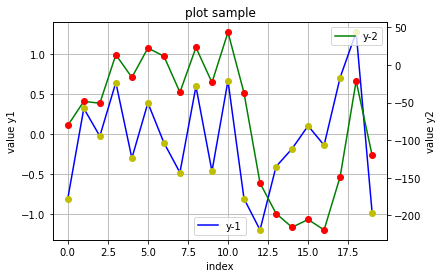

In [193]:
#第九课 两个y轴

fig, ax1 = plt.subplots()

np.random.seed(1000)
y = np.random.standard_normal(20)
x = range(len(y))
y2 = y*100
plt.plot(y,'b',lw=1.5,label='y-1')
plt.plot(y,'yo')
plt.grid(True)
plt.legend(loc=8)

plt.axis('tight')  #tight 使得所有数据可先   ,off关闭坐标轴和网格
plt.xlabel('index')
plt.ylabel('value y1')
plt.title('plot sample')
ax2 = ax1.twinx()
plt.plot(y2.cumsum(),'g',lw=1.5,label='y-2')
plt.plot(y2.cumsum(),'ro')
plt.legend(loc=0)
plt.ylabel('value y2')



Text(0, 0.5, 'value')

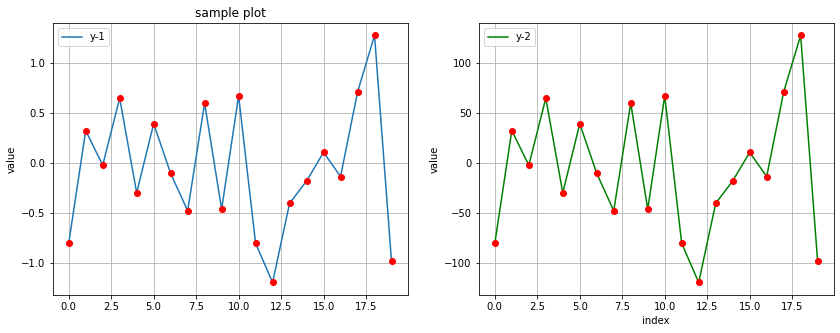

In [202]:
#上面是一张图，两根坐标轴
#下面是两张图，每张图一根坐标轴
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(y,lw=1.5,label='y-1')
plt.plot(y,'ro')
plt.grid(True)
plt.legend(loc=0)
plt.axis('tight')
plt.ylabel('value')
plt.title('sample plot')

plt.subplot(1,2,2)
plt.plot(y2,'g',lw=1.5,label='y-2')
plt.plot(y2,'ro')
plt.grid(True)
plt.legend(loc=0)
plt.axis('tight')
plt.xlabel('index')
plt.ylabel('value')

In [297]:
# 第十课 
# pandas进行date_range
# pickle进行二进制序列化
a = np.random.standard_normal((9,4))
a.round(6) #保留6位小数

df1 = pd.DataFrame(a)
df1.columns = [ 'No1','No2','No3','No4' ]

#自动生成时间序列
datas = pd.date_range('2021-1-1',periods=9, freq='M')
df1.index = datas

del df1['No1']
df1.describe()

#对象二进制序列化写入数据
a = [ gauss(1.5,2) for i in range(1000000)]
import pickle
pkl_file = open("./data.pkl",'bw')
%time pickle.dump(a, pkl_file)
pkl_file.close()
#对象二进制序列化读取数据
pkl_file1 = open("./data.pkl",'br')
%time b = pickle.load(pkl_file1)

#比较两个对象是否一致
np.allclose(np.array(a), np.array(b))

#等于0 也是一种比较对象值的方式
np.sum(np.array(a)-np.array(b))













Wall time: 36.1 ms
Wall time: 83 ms


0.0

In [299]:
#第十一课
# csv格式读写
rows = 5000
a = np.random.standard_normal((rows,5))
a.round(4)
t = pd.date_range(start='2018-1-1', periods=rows, freq='H')
csv_file = open("./data.csv",'w')
header = 'data,no1,no2,no3,no4,no5\n'
csv_file.write(header)
for t_, (no1, no2, no3, no4, no5) in zip(t, a):
    s = '%s,%f,%f,%f,%f,%f\n' %(t_, no1,no2,no3,no4,no5)
    csv_file.write(s)
csv_file.close()

csv_file = open("./data.csv",'r')
for i in range(5):
    print(csv_file.readline())
csv_file.close()




data,no1,no2,no3,no4,no5

2018-01-01 00:00:00,0.896570,-0.916095,1.016006,-0.076773,1.172085

2018-01-01 01:00:00,-0.118885,-0.586541,-0.700655,-0.891606,-0.942663

2018-01-01 02:00:00,1.789539,0.729734,-0.071046,-1.284591,1.565903

2018-01-01 03:00:00,0.239564,1.468773,-1.668009,0.533261,0.650014



In [27]:
# 第十二课
# 并行计算
def bsm_msc_valuation(strike):
    S0 = 100.; T=1.; r=0.05; vola=0.2; M=50; I=20000; dt=T/M; 
    rand = np.random.standard_normal((M+1, I))
    S=np.zeros((M+1, I))
    S[0] = S0
    for t in range(1, M+1):
        S[t] = S[t-1] * np.exp((r - 0.5 * vola**2)*dt + vola*np.sqrt(dt)*rand[t])
    value = (np.exp(-r * T) * np.sum(np.maximum(S[-1]- strike, 0))/I)
    return value

def seq_value(n):
    strikes = np.linspace(80, 120, n)
    option_values = []
    for strike in strikes:
        option_values.append(bsm_msc_valuation(strike))
    return strikes, option_values

n = 100
%time strikes, option_values_seq = seq_value(n)

Wall time: 3.8 s


In [3]:
%%writefile multiTest.py
# multiprocessing在jupyter中无法正确运行，所以写入一个单独文件，并且有main入口

from multiprocessing import Pool # 导入多进程中的进程池
import time
def foo_pool(x):
    time.sleep(2)
    return x*x

def log_result(x):
    print(x)

if __name__ == "__main__":
    pool = Pool(6)
    for i in range(6):
        pool.apply_async(foo_pool,args=(i,),callback= log_result)
    pool.close()
    pool.join()




Overwriting multiTest.py


In [35]:
%%writefile parBSMvalues.py
#写入文件，然后通过python执行
from multiprocessing import Pool # 导入多进程中的进程池
import numpy as np
import timeit

def bsm_msc_valuation(strike):
    S0 = 100.; T=1.; r=0.05; vola=0.2; M=50; I=20000; dt=T/M; 
    rand = np.random.standard_normal((M+1, I))
    S=np.zeros((M+1, I))
    S[0] = S0
    for t in range(1, M+1):
        S[t] = S[t-1] * np.exp((r - 0.5 * vola**2)*dt + vola*np.sqrt(dt)*rand[t])
    value = (np.exp(-r * T) * np.sum(np.maximum(S[-1]- strike, 0))/I)
    return value

def par_value():
    p=Pool(8) #创建含有十个10个进程的进程池
    n=100
    strikes = np.linspace(80, 120, n)
    option_values = []
    for strike in strikes:
        p.apply_async(bsm_msc_valuation,args=(strike,))
        
    p.close() #关闭进程池
    p.join()  #结束

if __name__ == "__main__":
    par_value()


Overwriting parBSMvalues.py


In [47]:
#第十三课
#之前是蒙特卡洛欧式期权定价，接下来使用二项式期权定价方法
from math import *
S0 = 100.0
T = 1.0   # call option maturity
r = 0.05
vola = 0.2

M = 1000   # time steps
dt = T / M   # length of time inteval
df = exp(-r * dt)  #discount factor per time interval

#binomial parameters
u = exp(vola * sqrt(dt))
d = 1/u
q = (exp(r * dt)-d) / (u-d)

import numpy as np
def binomial_py(strike):
    S = np.zeros((M+1, M+1),dtype=np.float64)
    S[0,0] = S0
    z1 = 0
    for j in range(1,M+1,1):
        z1 = z1 + 1
        for i in range(z1+1):
            S[i,j] = S[0,0]*(u**j) * (d**(i*2))

    iv = np.zeros((M+1,M+1),dtype=np.float64)
    z2=0
    for j in range(0, M+1, 1):
        for i in range(z2+1):
            iv[i,j] = max(S[i,j]-strike, 0)
        z2 = z2+1
    
    pv = np.zeros((M+1, M+1),dtype=np.float64)
    pv[:,M]=iv[:,M]
    z3 = M +1
    for j in range(M -1 , -1,-1):
        z3 = z3 - 1
        for i in range(z3):
            pv[i,j] = (q * pv[i,j+1] + (1-q)*pv[i+1, j +1])*df
    return pv[0,0]

%time print(binomial_py(100))

%time print(bsm_msc_valuation(100))


10.448584103764047
Wall time: 1.63 s
10.112085635465336
Wall time: 34.9 ms


Text(0, 0.5, 'f(x)')

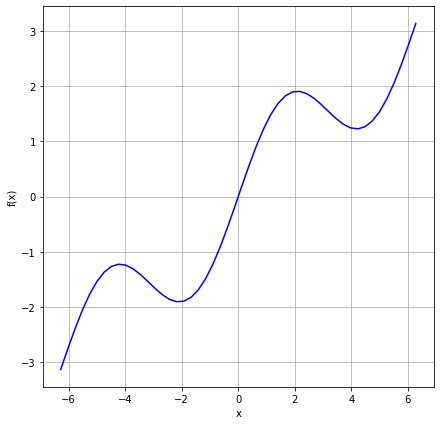

In [65]:
#第十一课
#逼近法

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def f(x):
    return np.sin(x)+0.5 * x
    
#插入足够多的值，图形才会是曲线
x = np.linspace(-2 * np.pi, 2*np.pi, 50)
plt.figure(figsize=(7,7))
plt.plot(x, f(x), 'b')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('f(x)')


[ 4.28841952e-01 -5.10280049e-17]


Text(0, 0.5, 'f(x)')

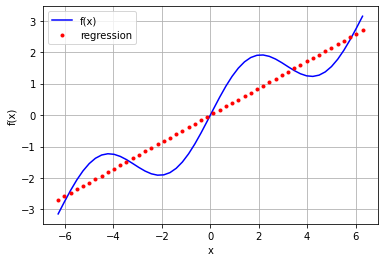

In [67]:
# 第十二课
# 线性回归

#根据输入数据，deg为1，则只能计算一次的单项式，计算得出线性回归的参数ax+b中的a和b
reg = np.polyfit(x, f(x), deg=1)
print(reg)
#根据线性回归得出的公式，重新计算x对应的结果，
ry = np.polyval(reg, x)

plt.plot(x, f(x), 'b', label='f(x)')
#ry为拟合后的线性结果，不能处理sin(x)部分
plt.plot(x, ry, 'r.', label='regression')
plt.legend(loc=0)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('f(x)')

[-5.47508597e-05  8.91377199e-19  4.99394999e-03 -4.51291773e-17
 -1.35368487e-01  4.93808671e-16  1.41870278e+00 -7.94486371e-16]


0.001776913475951788

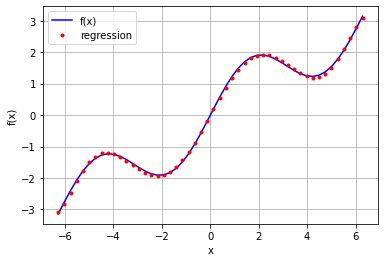

In [70]:
# 第十二课
# 回归
# 为了得出sin部分，得使用高次的单项式，
reg = np.polyfit(x, f(x), deg=7)
print(reg)
#根据回归得出的公式，重新计算x对应的结果，
ry = np.polyval(reg, x)

plt.plot(x, f(x), 'b', label='f(x)')
#ry为拟合后的结果，不能处理sin(x)部分
plt.plot(x, ry, 'r.', label='regression')
plt.legend(loc=0)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('f(x)')

#计算MSE均方差，很小
np.sum((f(x) - ry)**2) / len(x)


Text(0, 0.5, 'f(x)')

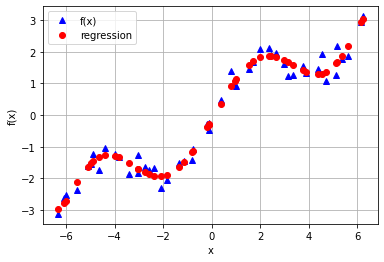

In [72]:
# 第十三课
# 回归 和 噪声
xn = np.linspace(-2 * np.pi, 2 * np.pi, 50)
xn = xn + 0.15 * np.random.standard_normal(len(xn))
yn = f(xn) + 0.25 * np.random.standard_normal(len(xn))

reg = np.polyfit(xn, yn, 7)
ry = np.polyval(reg, xn)

plt.plot(xn, yn, 'b^', label='f(x)')
plt.plot(xn, ry, 'ro', label='regression')
plt.legend(loc=0)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('f(x)')





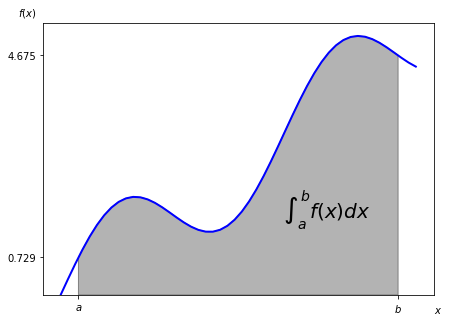

In [86]:

# 第十四课 
import scipy.integrate as sci
#求微积分 sin(x)+0.5x在0.5-9.5上的积分
def f(x):
    return np.sin(x) + 0.5*x

a=0.5
b=9.5
x = np.linspace(0,10,50)
y = f(x)

from matplotlib.patches import Polygon
fig, ax = plt.subplots(figsize=(7,5))
plt.plot(x, y, 'b', linewidth=2)
plt.ylim(ymin=0)


# area under the function between lower and upper limit
Ix  = np.linspace(a, b,50)
Iy = f(Ix)
#构造积分上边缘的50个点坐标，若坐标点数太少会导致绘图效果不好，加上起始两个点
verts = [(a, 0)] + list(zip(Ix,Iy)) + [(b,0)]
#根据坐标点，绘制多边形
poly = Polygon(verts, facecolor='0.7', edgecolor='0.5')
#将多边形图添加到坐标系上
ax.add_patch(poly)

#label
plt.text(0.75*(a+b), 1.5, r"$\int_a^b f(x)dx$", horizontalalignment='center', fontsize=20)
plt.figtext(0.9, 0.075, '$x$')
plt.figtext(0.075, 0.9, '$f(x)$')

ax.set_xticks((a,b))
ax.set_xticklabels(('$a$', '$b$'))
ax.set_yticks([f(a),f(b)])



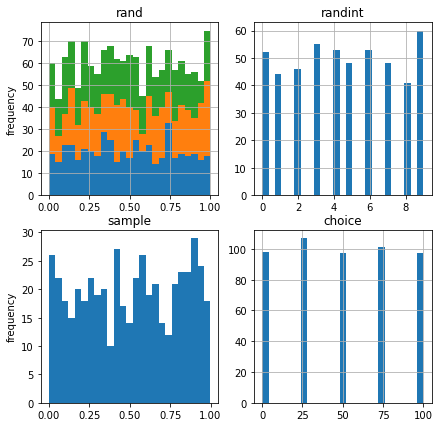

In [4]:
#第十五课
#随机
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
sample_size = 500
rn1 = npr.rand(sample_size, 3)
rn2 = npr.randint(0, 10, sample_size)
rn3 = npr.sample(sample_size)
a = [0, 25, 50, 75, 100]
rn4 = npr.choice(a, size=sample_size)

fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(7,7))
ax1.hist(rn1, bins=25, stacked=True)
ax1.set_title('rand')
ax1.set_ylabel('frequency')
ax1.grid(True)

ax2.hist(rn2, bins=25)
ax2.set_title('randint')
ax2.grid(True)

ax3.hist(rn3, bins=25)
ax3.set_title('sample')
ax3.set_ylabel('frequency')

ax4.hist(rn4, bins=25)
ax4.set_title('choice')
ax4.grid(True)






In [ ]:
rn1= npr.standard_normal(sample_size)
rn2 =npr.normal(100,20,sample_size)


In [ ]:
#第十六课
#随机过程和模拟
#金融中的随机过程被称为马尔科夫特性
#   明天的过程值只依赖于今天的过程状态，不依赖于其他历史状态，也称为“无记忆过程”

S0 = 100.
r=0.05
T=2.
sigma=0.25
I=10000
# 静态输出
ST1 = S0* np.exp((r - 0.5 * sigma ** 2) * T \
    + sigma* np.sqrt(T) * npr.standard_normal(I))

plt.hist(ST1, bins=50)
plt.xlabel('index level')
plt.ylabel('frequency')
plt.grid(True)



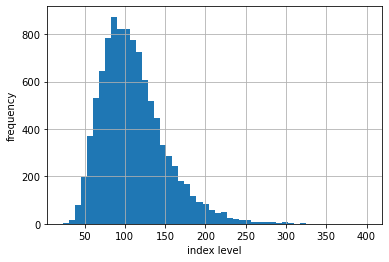

In [102]:
# 几何布朗动态运动
M = 50
dt = T / M
S = np.zeros((M+1, I))
S[0] = S0

for t in range(1, M+1):
    S[t] = S[t-1]*np.exp((r - 0.5 * sigma ** 2)*dt \
        + sigma * np.sqrt(dt) * npr.standard_normal(I))

plt.hist(S[-1],bins=50)
plt.xlabel('index level')
plt.ylabel('frequency')
plt.grid(True)

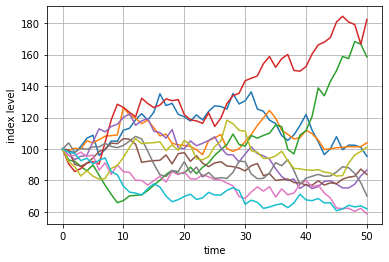

In [103]:
#输出动态路径
plt.plot(S[:, :10], lw=1.5)
plt.xlabel('time')
plt.ylabel('index level')
plt.grid(True)

In [104]:
#正态分布的随机数，
# 数据越多，生成的数据值也会变得越好，但是总是缺少理想值

print("%15s %15s" % ('Mean', 'Std.Deviation'))
print(31*'-')
for i in range(1,31,2):
    npr.seed(1000)
    sn = npr.standard_normal(i **2 * 10000)
    print("%15.12f %15.12f"%(sn.mean(), sn.std()))


           Mean   Std.Deviation
-------------------------------
-0.011870394558  1.008752430725
-0.002815667298  1.002729536352
-0.003847776704  1.000594044165
-0.003058113374  1.001086345326
-0.001685126538  1.001630849589
-0.001175212007  1.001347684642
-0.000803969036  1.000159081432
-0.000601970954  0.999506522127
-0.000147787693  0.999571756099
-0.000313035581  0.999646153704
-0.000178447061  0.999677277878
 0.000096501709  0.999684346792
-0.000135677013  0.999823841902
-0.000015726986  0.999906493379
-0.000039368519  1.000063091949


In [122]:
# 方差缩减技术
# 利用这种方法，可以快速使得随机数越来越好
print("%15s %15s" % ('Mean', 'Std.Deviation'))
print(31*'-')
for i in range(1,31,2):
    npr.seed(1000)
    sn = npr.standard_normal(i **2 * int(10000/2))
    sn = np.concatenate((sn, -sn))
    print("%15.12f %15.12f"%(sn.mean(), sn.std()))

print("%15s %15s" % ('Mean', 'Std.Deviation'))
print(31*'-')
for i in range(1,31,2):
    npr.seed(1000)
    sn = npr.standard_normal(i **2 * 10000)
    sn = (sn-sn.mean())/sn.std()
    print("%15.12f %15.12f"%(sn.mean(), sn.std()))
   
#整合上述两个方法
def gen_sn(M, I, anti_paths=True, mo_match=True):
    if anti_paths is True:
        sn = npr.standard_normal((M+1,int(I/2)))
        sn = np.concatenate((sn, -sn), axis=1)
    else:
        sn = npr.standard_normal((M+1,I))
    
    if mo_match is True:
        sn = (sn - sn.mean()) / sn.std()
        return sn


           Mean   Std.Deviation
-------------------------------
 0.000000000000  1.009653753942
-0.000000000000  1.000413716783
 0.000000000000  1.002925061201
-0.000000000000  1.000755212673
 0.000000000000  1.001636910076
-0.000000000000  1.000726758438
-0.000000000000  1.001621265149
 0.000000000000  1.001203722778
-0.000000000000  1.000556669784
 0.000000000000  1.000113464185
-0.000000000000  0.999435175324
 0.000000000000  0.999356961431
-0.000000000000  0.999641436845
-0.000000000000  0.999642768905
-0.000000000000  0.999638303451
           Mean   Std.Deviation
-------------------------------
 0.000000000000  1.000000000000
 0.000000000000  1.000000000000
 0.000000000000  1.000000000000
-0.000000000000  1.000000000000
-0.000000000000  1.000000000000
 0.000000000000  1.000000000000
 0.000000000000  1.000000000000
-0.000000000000  1.000000000000
-0.000000000000  1.000000000000
-0.000000000000  1.000000000000
 0.000000000000  1.000000000000
-0.000000000000  1.000000000000
-0.00000

# 第十七课 蒙特卡洛动态估值

In [124]:


S0 = 100.0
r = 0.05
sigma = 0.25
T = 1.0
I = 50000

def gbm_mcs_stat(K):
    '''
        Valuation of European call option in Black-Scholes-Merton by Monte Carlo simulation
    '''
    sn = gen_sn(1, I)
    ST = S0 * np.exp((r-0.5*sigma**2)*T +sigma * np.sqrt(T)*sn[1])
    hT = np.maximum(ST - K, 0)
    C0 = np.exp( -r * T)* 1 / I * np.sum(hT)
    return C0

gbm_mcs_stat(K=105.)

# 接下来考虑动态模拟，欧式期权，支持call和put
def gbm_mcs_dyna(K, option='call'):
    dt = T / M
    S = np.zeros((M + 1, I))
    S[0] = S0
    sn = gen_sn(M, I)
    for t in range(1, M+1):
        S[t] = S[t-1] * np.exp((r - 0.5*sigma**2)*dt+sigma*np.sqrt(dt)*sn[t])
    # 到期盈利
    if option=='call':
        hT = np.maximum(S[-1] - K,0)
    else:
        hT = np.maximum(K-S[-1], 0)
    # 根据模拟到期盈利，计算当前定价
    C0 = np.exp(-r * T)*1/ I * np.sum(hT)
    return C0

print(gbm_mcs_dyna(K=110., option='call'))
print(gbm_mcs_dyna(K=110., option='put'))



    

8.068131716429221
12.696024854124522


[ 80.  85.  90.  95. 100. 105. 110. 115. 120.]


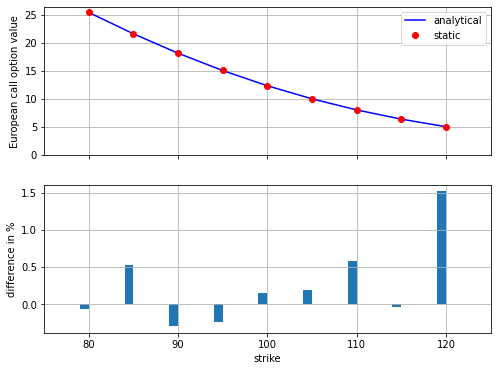

In [133]:
# 比较蒙特卡洛动态模拟计算出来的定价 
# 与  bs公式计算出来的定价

stat_res = []
dyna_res = []
anal_res = []

k_list = np.arange(80., 120.1, 5.)
print(k_list)
for K in k_list:
    # 静态模拟计算
    stat_res.append(gbm_mcs_stat(K))
    # 动态模拟计算
    dyna_res.append(gbm_mcs_dyna(K))
    # 分析计算
    anal_res.append(bsm_call_value(S0, K, T, r, sigma))
stat_res = np.array(stat_res)
dyna_res = np.array(dyna_res)
anal_res = np.array(anal_res)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
ax1.plot(k_list, anal_res, 'b', label='analytical')
ax1.plot(k_list, stat_res, 'ro', label='static')
ax1.set_ylabel('European call option value')
ax1.grid(True)
ax1.legend(loc=0)
ax1.set_ylim(ymin=0)
width = 1.0
ax2.bar(k_list - width/2, (anal_res - stat_res)/ anal_res * 100, width)
ax2.set_xlabel('strike')
ax2.set_ylabel('difference in %')
ax2.set_xlim(left=75, right=125)
ax2.grid(True)

#根据图，可以看到两个值的误差很小，只有1.5%

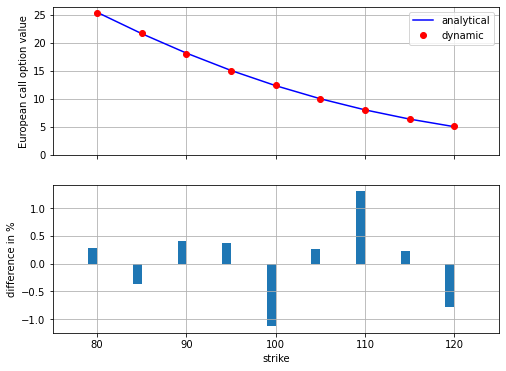

In [134]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
ax1.plot(k_list, anal_res, 'b', label='analytical')
ax1.plot(k_list, dyna_res, 'ro', label='dynamic')
ax1.set_ylabel('European call option value')
ax1.grid(True)
ax1.legend(loc=0)
ax1.set_ylim(ymin=0)
width = 1.0
ax2.bar(k_list - width/2, (anal_res - dyna_res)/ anal_res * 100, width)
ax2.set_xlabel('strike')
ax2.set_ylabel('difference in %')
ax2.set_xlim(left=75, right=125)
ax2.grid(True)

# 第十八课 美式期权定价

In [136]:

# 刚刚演示的是欧式期权，接下来看看美式期权
# 美式期权比欧式期权复杂，因为它是到期日前任意时间均可以行权，就会有最优截止问题

# 最小二乘回归LSM  蒙特卡洛方法 
def gbm_mcs_amer(K, option='call'):
    '''
    Valuation of American option in BSM by Monte Carlo Simulation by LSM algorithm

    '''
    dt = T / M
    df = np.exp(-r * dt)
    S = np.zeros((M+1,I))
    S[0] = S0
    sn = gen_sn(M, I)
    for t in range(1, M+1):
        S[t]=S[t-1] * np.exp((r -0.5 *sigma **2) * dt
            + sigma*np.sqrt(dt) * sn[t])
    #case-based calculation of payoff
    if option == 'call':
        h = np.maximum(S-K, 0)
    else:
        h = np.maximum(K-S, 0)
    #LSM algorithm
    V = np.copy(h)
    for t in range(M-1, 0, -1):
        reg = np.polyfit(S[t], V[t+1] * df, 7)
        C= np.polyval(reg, S[t])
        V[t] = np.where(C > h[t], V[t+1]*df, h[t])

    #MCS estimator
    C0 = df*1/I*np.sum(V[1])
    return C0

print(gbm_mcs_amer(110., option='call'))
print(gbm_mcs_amer(110., option='put'))



7.780158691173945
13.634017498060352


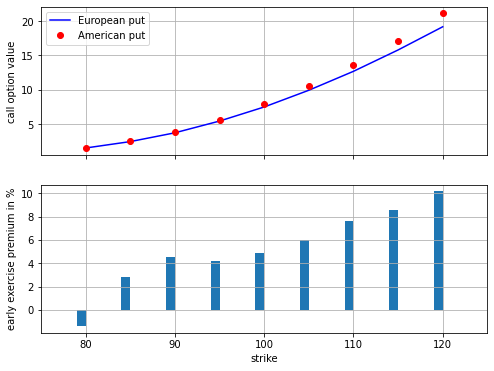

In [137]:
# 比较欧式期权和美式期权价值
# 两者的差异通常称为提前行权溢价

euro_res= []
amer_res=[]
k_list = np.arange(80., 120.1, 5.)
for K in k_list:
    euro_res.append(gbm_mcs_dyna(K, 'put'))
    amer_res.append(gbm_mcs_amer(K, 'put'))
euro_res = np.array(euro_res)
amer_res = np.array(amer_res)

fig, (ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(8,6))
ax1.plot(k_list, euro_res, 'b', label='European put')
ax1.plot(k_list, amer_res, 'ro', label='American put')
ax1.set_ylabel('put option value')
ax1.grid(True)
ax1.legend(loc=0)
width=1.0
ax2.bar(k_list - width/2, (amer_res - euro_res)/euro_res * 100, width)
ax2.set_xlabel('strike')
ax2.set_ylabel('early exercise premium in %')
ax2.set_xlim(left=75, right=125)
ax2.grid(True)

#根据图表数据，一般美式期权的价格是要高于欧式期权的，不同行权价的溢价不同，越实质溢价貌似越高，多的有10%





# 第十九课 风险测度中两个风险测度
Var 风险价值 是最广泛使用的风险测度之一，也受争议
Var表示在给定时间周期中不超过某种置信度（概率）的损失

Confidence Level    Value at risk
---------------------------------
           99.99            22.59
           99.90            19.21
           99.00            15.26
           97.50            13.04
           95.00            11.03
           90.00             8.70


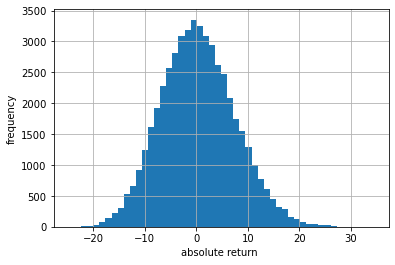

In [147]:
import scipy.stats as scs
S0 = 100.
r = 0.05
sigma = 0.25
T = 30/ 365.
ST = S0 * np.exp((r-0.5 * sigma ** 2) * T 
    + sigma * np.sqrt(T) * npr.standard_normal(I))
#计算盈亏，按照大到小排序
R_gbm = np.sort(ST-S0)
#显示不同亏损的频率次数
plt.hist(R_gbm, bins=50)
plt.xlabel('absolute return ')
plt.ylabel('frequency')
plt.grid(True)


#计算概率
percs = [0.01, 0.1, 1. , 2.5, 5.0, 10.0]

# 统计数据分布概率
var = scs.scoreatpercentile(R_gbm, percs)
print('%16s %16s' % ('Confidence Level', 'Value at risk'))
print(33*'-')
for pair in zip(percs, var):
    print('%16.2f %16.2f'%(100-pair[0], -pair[-1]))
# 结果是 小于99.00% Var为8.7

0
CVar: 0.5133783167202854
S0_CVA: 99.62412011027348
S0_adj: 99.48662168327971
违约次数： 1026


(0.0, 175.0)

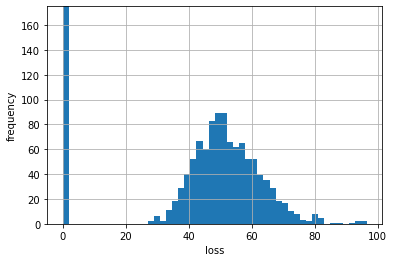

In [24]:
#信用风险价值(CVaR) 以及 信用价值调整(CVA)
# 对手方无法履行其义务所发生的的风险的一个测试。
#   两个假设: 违约概率p 和 （平均）损失水平L
S0 = 100.
r = 0.05
sigma = 0.2
T = 1.
I = 100000
ST = S0 * np.exp((r-0.5*sigma ** 2)* T + sigma *np.sqrt(T)*npr.standard_normal(I))
#固定损失水平L，对手违约概率p
L=0.5
p=0.01
# 只发生一次违约
D = npr.poisson(p * T, I)

D = np.where(D>1, 1, D)

# 如果没有违约，风险中立价值如下
np.exp(-r * T)*1 / I * np.sum(ST)
# 信用风险亏损值
CVaR= np.exp(-r*T)*1/I*np.sum(L * D * ST)
print("CVar:",CVaR)
#经过信用风险调整之后的资产值
S0_CVA = np.exp(-r*T)*1/I * np.sum((1-L*D)*ST)
print("S0_CVA:",S0_CVA)
# S0_CVA基本等于S0-CVaR
S0_adj = S0 - CVaR
print("S0_adj:",S0_adj)

#违约分布，这里模拟了10万次，违约概率为0.01,所以如下违约次数大概再1000左右。

print("违约次数：",np.count_nonzero(L*D*ST))

plt.hist(L*D*ST, bins=50)
plt.xlabel('loss')
plt.ylabel('frequency')
plt.grid(True)
plt.ylim(ymax=175)







C0: 10.524423492443585
CVar: 0.05251220007507386
C0_CVA: 10.471911292368512


(0.0, 350.0)

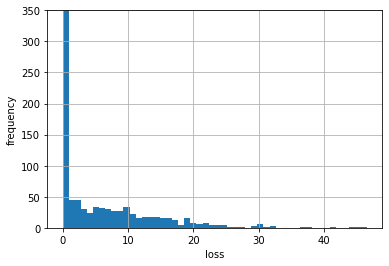

In [34]:
#欧式看涨期权

K =  100.
#看涨期权到期价值
hT = np.maximum(ST - K, 0 )

C0 = np.exp(-r * T) * 1/I * np.sum(hT)
print("C0:",C0)

CVaR = np.exp(-r*T) *1/I * np.sum(L * D * hT)
print("CVar:",CVaR)
# (1-L*D) 表示 根据损失概率分布D和损失水平L，将原先的盈利需要减去这部分亏损
C0_CVA = np.exp(-r*T)*1/I *np.sum((1-L*D)*hT)
# 调整后的期权价值
print("C0_CVA:",C0_CVA)

#期权的CVaR和上一次的常规资产是不大一样的分布
plt.hist(L * D * hT, bins=50)
plt.xlabel('loss')
plt.ylabel('frequency')
plt.grid(True)
plt.ylim(ymax=350)



# 第二十课 统计学


-0.03719999999999998
105.12645392478755


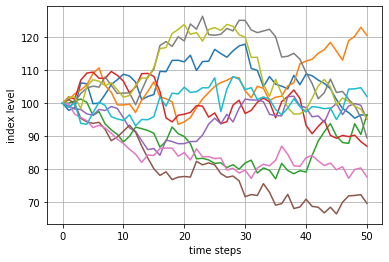

In [42]:
import numpy as np
np.random.seed(1000)
import scipy.stats as scs
import matplotlib as mpl
import matplotlib.pyplot as plt

# 几何布朗运动生成蒙特卡洛路径
def gen_paths(S0, r, sigma, T, M, I):
    dt = float(T)/M
    paths = np.zeros((M+1, I), np.float64)
    paths[0] = S0
    for t in range(1,M+1):
        rand = np.random.standard_normal(I)
        rand = (rand - rand.mean())/rand.std()
        paths[t]=paths[t-1]*np.exp((r-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*rand)
    return paths


#我们来模拟一下
S0 = 100.
r=0.05
sigma=0.2
T=1.0
M=50
I=250000
paths = gen_paths(S0, r, sigma, T, M, I)
plt.plot(paths[:,:10])
plt.grid(True)
plt.xlabel('time steps')
plt.ylabel('index level')

#计算路径的收益率: 从第二天数据开始除以第一天数据，最后一天除以之前最后第二天
log_returns = np.log(paths[1:] / paths[0:-1])


(log_returns[:,0].round(4))

print(np.average(paths[-1]))

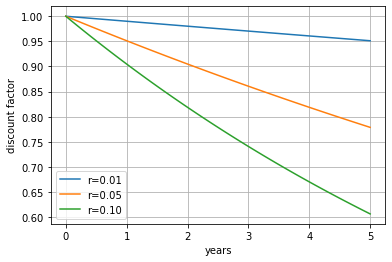

In [46]:
# 短期利率的计算

# 在期权的计算过程中，或者经济分析中，固定短期利率世界中，折现因此 D(t) = np.exp(-r*t)，这里考虑的是连续复利，就是把t时间分隔成非常小的很多个时间进行的复利运算
# 
# 在正常财务的年利率世界中，F代表未来，P代表现在，
# 折现是用 现值 P = F / (1+r)^t， 连续复利，实际上就是用这种年复利方式的公式计算，
# 
# 【推导过程】
# 将一年分割成n次复利  F = P * (1+r/n)^nt，当n很小时，公式就等于 F = P * e^(rt), 
# 所以P = F * e^(-rt)，知道F，就可以推倒出现在的值
import numpy as np
def discount_factor(r, t):
    df = np.exp(-r*t)
    return df

t = np.linspace(0,5)
for r in [0.01,0.05,0.1]:
    plt.plot(t, discount_factor(r, t), label='r=%4.2f'%r, lw=1.5)
plt.xlabel('years')
plt.ylabel('discount factor')
plt.grid(True)
plt.legend(loc=0)




In [53]:
# 将上述方法，放入到一个类中

class Short_rate(object):
    def __init__(self, name, rate):
        self.name = name
        self.rate = rate
    
    def get_discount_factors(self, time_list):
        time_list = np.array(time_list)
        return np.exp(-self.rate*time_list)

    def get_discount_factors_origin(self, time_list):
        time_list = np.array(time_list)
        return 1/np.power(1+self.rate,time_list)
    
#利率设置为0.05
sr = Short_rate('r',0.05)
#计算不同时间下的折现利率
time_list = [0.0,1.0,2.0]
disc_facts= sr.get_discount_factors(time_list)

cash_flows = np.array([-100,50,75])
#计算现金流的折现，采用连续复利
print(disc_facts*cash_flows)
#计算现金流的折现，采用年复利率
print(cash_flows* sr.get_discount_factors_origin(time_list))


[-100.           47.56147123   67.86280635]
[-100.           47.61904762   68.02721088]


In [58]:
#将上面折现方法设计到类中，方便使用
class cash_flow_series(object):
    def __init__(self, name, time_list, cash_flows, short_rate):
        self.name = name
        self.time_list = time_list
        self.cash_flows = cash_flows
        self.short_rate = short_rate
    def present_value_list(self):
        df = self.short_rate.get_discount_factors(self.time_list)
        return np.array(self.cash_flows)*df
    def net_present_value(self):
        return np.sum(self.present_value_list())

#相同短期利率下不同时间，不同现金流的NPV
sr.rate = 0.05
cfs = cash_flow_series('cfs',time_list, cash_flows, sr)
cfs.present_value_list()

cfs.net_present_value()


15.424277577732667

Text(0, 0.5, 'net present value')

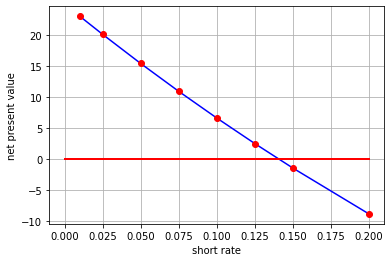

In [71]:
# 将上述相同利率，扩展为不同利率,计算净现值

class cfs_sensitivity(cash_flow_series):
    def npv_sensitivity(self, short_rates):
        npvs = []
        for rate in short_rates:
            sr.rate = rate
            npvs.append(self.net_present_value())
        return np.array(npvs)
    
short_rates = [0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.2]
cfs_sens = cfs_sensitivity('cfs',time_list, cash_flows,sr)
npvs = cfs_sens.npv_sensitivity(short_rates)

plt.plot(short_rates, npvs, 'b')
plt.plot(short_rates, npvs, 'ro')
#画一条水平线的方法
plt.plot((0, max(short_rates)), (0,0), 'r', lw=2)
plt.grid(True)
plt.xlabel('short rate')
plt.ylabel('net present value')



In [83]:
# 假设一种高风险股票 ，现价 10， 第二天 60% 概率涨到20，40% 概率为0
# 假设一种无风险债券，现价 10， 第二天 还是10，收益0.
# 股票的预期收益= (0.6*20+0.4*0)/10 -1 = 0.2。
# 也叫股票风险特性的风险收益

'''
行权价15的对应看涨期权，股票涨到20，期权收益为5，股票跌到15以下，期权收益为0.
期权定价的方法1：公允价值 = 60% * 5 + 40%*0 = 3 。
期权定价的方法2：用证券的组合复制期权收益，
    1份股票，对应60%的收益为 20，那么0.25的股票，对应期权收益0.25*20=5，若40%，对应期权收益0
    0.25份股票同样等价于1份期权的收益。而0.25份股票价格只有2.5，小于原先的3。
'''

'''
股票的风险收益虽然使用60%和40%来测定，但是无法完全靠自己对冲的，因为实际上要么100%亏，要么100%赚。

但是投资组合可以无风险的复制期权的收益，卖出期权相当于完全对冲了风险。
所以由期权和对冲头寸组成的完全对冲必须等于无风险利率收益。

'''


# 首先构建一个时间类，用于计算日期对应小数的转换
import datetime as dt
def get_year_deltas(data_list, day_count=365):
    start = data_list[0]
    delta_list = [(date-start).days/day_count for date in data_list]
    return np.array(delta_list)



dates = [dt.datetime(2021,1,1),dt.datetime(2021,7,1),
dt.datetime(2022,1,1)]

dates = get_year_deltas(dates)


# 固定短期利率下的风险中立折现

class constant_short_rate(object):
    def __init__(self, name, short_rate):
        self.name = name
        self.short_rate = short_rate
        if short_rate <0:
            raise ValueError('Short rate negative.')

    def get_discount_factors(self, date_list, dtobjects=True):
        if dtobjects is True:
            dlist = get_year_deltas(date_list)
        else:
            dlist = np.array(date_list)
        dflist = np.exp(self.short_rate* (-dlist))
        return np.array((date_list, dflist)).T

    
csr = constant_short_rate('csr',0.05)
csr.get_discount_factors(dates, False)









array([[0.        , 1.        ],
       [0.49589041, 0.97551034],
       [1.        , 0.95122942]])